# Proyecto Mineria de Datos: Credit Scores

### Parte 1: Limpieza de datos

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp

import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

## Datos

In [2]:
os.chdir('/home/juanpalms/Desktop/Mineria de Datos/Proyecto')

In [3]:
os.getcwd()

'/home/juanpalms/Desktop/Mineria de Datos/Proyecto'

In [4]:
datos_train=pd.read_csv('Data/train.csv')

In [5]:
datos_test=pd.read_csv('Data/test.csv')

In [6]:
datos_train.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [7]:
columns_headers=list(datos_train.columns.values)
print(columns_headers)

['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']


In [8]:
#Eliminamos variables que no van a aportar nada al analisis
datos_train.drop(["SSN","Credit_History_Age","Name"], axis=1, inplace=True)

### Lista de variables completas para analisis

1) ID________________________________________#No necesita cambios                      
2) Customer ID_______________________________#No necesita cambios   
3) Month______________________________________#No necesita cambios                       
4) Age________________________________________#Cambios: quitar outliers y missing values                       
5) Occupation__________________________________#Se quitaron missing values              
6) Annual_Income______________________________#No necesita cambios         
7) Monthly_Inhand_Salary______________________#Cambios: quitar outliers y missing values    
8) Num_Bank_Account____________________________#Cambios: quitar outliers y missing values 
9) Num_Credit_Card____________________________#Cambios: quitar outliers y missing values            
10) Interest_Rate_____________________________#Cambios: quitar outliers y missing values             
11) Num_of_Loan_______________________________#Cambios: quitar outliers y missing values                
12) Type_of_Loan             #Falta hacer One Hot Encoding
13) Delay_from_due_date      #esta se ve normal por ahora la dejo asi  
14) Num_of_Delayed_Payment_______________________________#Cambios: quitar outliers y missing values   
15) Changed_Credit_Limit________________________________#Cambios: quitar outliers y missing values   
16) Num_Credit_Inquiries________________________________#Cambios: quitar outliers y missing values      
17) Credit_Mix                
18) Outstanding_Debt          
19) Credit_Utilization_Ratio  
20) Payment_of_Min_Amount     
21) Total_EMI_per_month       
22) Amount_invested_monthly    
23) Payment_Behaviour         
24) Monthly_Balance           
25) Credit_Score              

In [9]:
#Establecemos como indice la variable "Customer_ID" esto nos va a dejar con indices repetidos, pero es util
#para poder reemplazar valores faltantes con la moda intra-individuo

datos_train.set_index(["Customer_ID"],inplace=True)

In [10]:
#Nos concentramos en la limpieza de las variables relevantes
datos_train.shape

(100000, 24)

### Variables con typos  o missing values

In [11]:
#Hacemos manipulaciones iniciales de algunas variables numericas que tienen caracteres especiales
datos_train['Age'] = datos_train['Age'].str.replace('_', '').astype('int64')
datos_train['Annual_Income'] = datos_train['Annual_Income'].str.replace('_', '').astype('float64')
datos_train['Num_of_Loan'] = datos_train['Num_of_Loan'].str.replace('_', '').astype('float64')
datos_train['Num_of_Delayed_Payment'] = datos_train['Num_of_Delayed_Payment'].str.replace('_', '').astype('float64')
datos_train['Changed_Credit_Limit']=pd.to_numeric(datos_train['Changed_Credit_Limit'], errors='coerce')
datos_train['Outstanding_Debt'] = datos_train['Outstanding_Debt'].str.replace('_', '').astype('float64')
datos_train['Amount_invested_monthly'] = datos_train['Amount_invested_monthly'].str.replace('_', '').astype('float64')

In [12]:
datos_train["Outstanding_Debt"].describe()

count    100000.000000
mean       1426.220376
std        1155.129026
min           0.230000
25%         566.072500
50%        1166.155000
75%        1945.962500
max        4998.070000
Name: Outstanding_Debt, dtype: float64

A CONTINUACION SE ARREGLA EL ERROR DE  OTLIERS O MISSSING VALUES

In [13]:
####PASO 1) Separamos los meses del data set. En el training set tenemos 8 meses etiquetados con la y objetivo
# cada individuo aparece 8 veces en el data set por lo que nos interesa obtener modas de las variables que no cambian
#en el tiempo: Age, Occupation, Annual Income,Monthly_Inhand_Salary.
#Hacemos un data set para cada mes en el train set
enero=datos_train[datos_train['Month']=="January"]
febrero=datos_train[datos_train['Month']=="February"]
marzo=datos_train[datos_train['Month']=="March"]
abril=datos_train[datos_train['Month']=="April"]
mayo=datos_train[datos_train['Month']=="May"]
junio=datos_train[datos_train['Month']=="June"]
julio=datos_train[datos_train['Month']=="July"]
agosto=datos_train[datos_train['Month']=="August"]

In [14]:
import functools as ft

In [15]:
###PASO 2) Este paso se va a repetir para cada variable a la cual querramos sacarle la moda
#En esta celda se crea un data set solo incluyendo las edades, en esta celda, se esta ordenando
# en columnas las edadades para cada mes y en cada row estaran todas las edades de los individuos formadas del
#mes de Enero al mes de Agosto, esto nos permitira sacar la moda de manera horizontal (moda para cada row)

#AGE
edades=[enero['Age'],febrero['Age'],marzo['Age'],abril['Age'],mayo['Age'],junio['Age'],julio['Age'],agosto['Age']]
df_edad = ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), edades)

#OCCUPATION
Ocupacion=[enero['Occupation'],febrero['Occupation'],marzo['Occupation'],abril['Occupation'],mayo['Occupation'],junio['Occupation'],julio['Occupation'],agosto['Occupation']]
df_ocupacion = ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Ocupacion)

#MONTHLY_INHAND_SALARY
Salario=[enero['Monthly_Inhand_Salary'],febrero['Monthly_Inhand_Salary'],marzo['Monthly_Inhand_Salary'],abril['Monthly_Inhand_Salary'],mayo['Monthly_Inhand_Salary'],junio['Monthly_Inhand_Salary'],julio['Monthly_Inhand_Salary'],agosto['Monthly_Inhand_Salary']]
df_salario = ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Salario)

#MNUM_BANK_ACCOUNTS
Cuentas_numero=[enero['Num_Bank_Accounts'],febrero['Num_Bank_Accounts'],marzo['Num_Bank_Accounts'],abril['Num_Bank_Accounts'],mayo['Num_Bank_Accounts'],junio['Num_Bank_Accounts'],julio['Num_Bank_Accounts'],agosto['Num_Bank_Accounts']]
df_cuentas= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Cuentas_numero)

#MNUM_CREDIT_CARDS
Tarjetas_credito=[enero['Num_Credit_Card'],febrero['Num_Credit_Card'],marzo['Num_Credit_Card'],abril['Num_Credit_Card'],mayo['Num_Credit_Card'],junio['Num_Credit_Card'],julio['Num_Credit_Card'],agosto['Num_Credit_Card']]
df_tdc= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Tarjetas_credito)


#Interest Rate
Interes=[enero['Interest_Rate'],febrero['Interest_Rate'],marzo['Interest_Rate'],abril['Interest_Rate'],mayo['Interest_Rate'],junio['Interest_Rate'],julio['Interest_Rate'],agosto['Interest_Rate']]
df_interes= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Interes)

#NUM OF LOAN
NumLOan=[enero['Num_of_Loan'],febrero['Num_of_Loan'],marzo['Num_of_Loan'],abril['Num_of_Loan'],mayo['Num_of_Loan'],junio['Num_of_Loan'],julio['Num_of_Loan'],agosto['Num_of_Loan']]
df_loan= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), NumLOan)


#NUM DELAYED
NumDelayed=[enero['Num_of_Delayed_Payment'],febrero['Num_of_Delayed_Payment'],marzo['Num_of_Delayed_Payment'],abril['Num_of_Delayed_Payment'],mayo['Num_of_Delayed_Payment'],junio['Num_of_Delayed_Payment'],julio['Num_of_Delayed_Payment'],agosto['Num_of_Delayed_Payment']]
df_ndelayed= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), NumDelayed)



#ANGED CREDIT LIMIT
Changed_limit=[enero['Changed_Credit_Limit'],febrero['Changed_Credit_Limit'],marzo['Changed_Credit_Limit'],abril['Changed_Credit_Limit'],mayo['Changed_Credit_Limit'],junio['Changed_Credit_Limit'],julio['Changed_Credit_Limit'],agosto['Changed_Credit_Limit']]
df_chlimit= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Changed_limit)


#NUM CREDIT INQUIRIES
Credit_inquiries=[enero['Num_Credit_Inquiries'],febrero['Num_Credit_Inquiries'],marzo['Num_Credit_Inquiries'],abril['Num_Credit_Inquiries'],mayo['Num_Credit_Inquiries'],junio['Num_Credit_Inquiries'],julio['Num_Credit_Inquiries'],agosto['Num_Credit_Inquiries']]
df_credinquiries= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Credit_inquiries)

#AMOUNT INVESTED MONTHLY
Amount_invested=[enero['Amount_invested_monthly'],febrero['Amount_invested_monthly'],marzo['Amount_invested_monthly'],abril['Amount_invested_monthly'],mayo['Amount_invested_monthly'],junio['Amount_invested_monthly'],julio['Amount_invested_monthly'],agosto['Amount_invested_monthly']]
df_amountinvested= ft.reduce(lambda left, right: pd.merge(left, right, on=["Customer_ID"]), Amount_invested)

In [16]:
#Asi se ve el data set final para cada variable que vamos a reemplazar
#(no te preocupes si se repite el nombre de la columna, python lo hace porque no tiene
# otros nombres que agarrar, por eso me saltan advertencias en rosa arriba, pero no pasa nada oiga)
#df_edad
df_chlimit

,Changed_Credit_Limit_x,Changed_Credit_Limit_y,Changed_Credit_Limit_x,Changed_Credit_Limit_y,Changed_Credit_Limit_x,Changed_Credit_Limit_y,Changed_Credit_Limit_x,Changed_Credit_Limit_y
Customer_ID,,,,,,,,
CUS_0xd40,11.27,11.27,NaN,6.27,11.27,9.27,11.27,11.27
CUS_0x21b1,5.42,7.42,5.42,5.42,6.42,5.42,5.42,5.42
CUS_0x2dbc,7.10,7.10,11.10,9.10,7.10,7.10,7.10,7.10
CUS_0xb891,1.99,1.99,1.99,-2.01,-1.01,-3.01,1.99,1.99
CUS_0x1cdb,2.58,2.58,2.58,2.58,2.58,2.58,2.58,2.58
...,...,...,...,...,...,...,...,...
CUS_0x372c,4.10,-0.90,12.10,5.10,5.10,5.10,5.10,5.10
CUS_0xf16,5.69,5.69,5.69,5.69,5.69,0.69,11.69,5.69
CUS_0xaf61,5.38,5.38,5.38,5.38,5.38,5.38,5.38,5.38


Hacemos series independientes para cada una de las variables a emplear para sacar modas

In [17]:
#AGE
#Cuando le sacamos la moda o promedio a las variables puede traer mas de una columna, en caso de que sea multimodal la variable
#en nuestros datos esto puede pasar, por ejemplo si tenemos varios missing values y el Nan se vuele una moda
#para eso, la segunda linea del codigo se queda solamente con la primera columna del df modes creado en la 
#primera linea del codigo de esta celda
modes_age=df_edad.mode(axis='columns', numeric_only=True) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
modes_age=modes_age[0] #Solo conservamos la primera columna

#OCCUPATION
modes_occupation=df_ocupacion.mode(axis='columns', numeric_only=False) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
modes_occupation=modes_occupation[0] #Solo conservamos la primera columna


#MONTHLY_INHAND_SALARY
mean_salary=df_salario.mean(axis='columns', numeric_only=True) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna



#NUM_BANK_ACCOUNT
mode_account=df_cuentas.mode(axis='columns', numeric_only=True) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
mode_account=mode_account[0] #Solo conservamos la primera columna


#NUM_CREDIT_CARDS
mode_tdc=df_tdc.mode(axis='columns', numeric_only=True) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
mode_tdc=mode_tdc[0] #Solo conservamos la primera columna

#INTEREST_RATE
mode_ir=df_interes.mode(axis='columns', numeric_only=True) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
mode_ir=mode_ir[0] #Solo conservamos la primera columna

#INUMOFLOAN
mode_loan=df_loan.mode(axis='columns', numeric_only=True) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
mode_loan=mode_loan[0] #Solo conservamos la primera columna


#NUM DELAYED
mode_ndelayed=df_ndelayed.mode(axis='columns', numeric_only=True) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
mode_ndelayed=mode_ndelayed[0] #Solo conservamos la primera columna


#Changed Limit
mean_chlimit=df_chlimit.mode(axis='columns', numeric_only=False) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
mean_chlimit=mean_chlimit[0] #Solo conservamos la primera columna

#Credit Inquiries
mode_crinquiries=df_credinquiries.mode(axis='columns', numeric_only=False) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
mode_crinquiries=mode_crinquiries[0] #Solo conservamos la primera columna

#Credit Inquiries
mean_amount=df_amountinvested.mean(axis='columns', numeric_only=False) #sacamos modas para cada row, dice columna pq la iteracion la hace sobre la columna
#Solo conservamos la primera columna


Aqui sacamos algunas estadisticas de las modas para checar que todo esta en orden

In [18]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#AGE
print('Edades\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(modes_age.max(), modes_age.min(),modes_age.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9]),modes_age.count().sum()))
#aqui hago que la moda sea un int16
modes_age=modes_age.astype('int16')

Edades
Maximum value: 56.0
Minimum value 14.0
Quantiles:
0.1    19.0
0.2    23.0
0.3    26.0
0.4    29.0
0.5    33.0
0.6    36.0
0.7    40.0
0.8    43.0
0.9    48.0
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [19]:
#OCCUPATION
#aqui hago que la moda sea un categorical
modes_occupation=modes_occupation.astype('category')
modes_occupation= modes_occupation.str.replace('_______', 'Other').astype('category')
print(' Ocupacion\nNumero de valores unicos: {}\nNumber of nonmissing {}\nValores unicos:{}\nTipo de dato:{}'
      .format(modes_occupation.nunique(),modes_occupation.count().sum(),modes_occupation.unique(),
              modes_occupation.dtype))

 Ocupacion
Numero de valores unicos: 16
Number of nonmissing 12500
Valores unicos:['Scientist', 'Teacher', 'Engineer', 'Entrepreneur', 'Developer', ..., 'Musician', 'Mechanic', 'Writer', 'Architect', 'Other']
Length: 16
Categories (16, object): ['Accountant', 'Architect', 'Developer', 'Doctor', ..., 'Other', 'Scientist', 'Teacher', 'Writer']
Tipo de dato:category


In [20]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#MONTHLY_INHAND_SALARY
print('Salario Mensual\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mean_salary.max(), mean_salary.min(),mean_salary.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9]),mean_salary.count().sum()))
#aqui hago que la moda sea un int16
mean_salary=mean_salary.astype('float16')


Salario Mensual
Maximum value: 15204.633333333331
Minimum value 303.6454166666667
Quantiles:
0.1    1104.999417
0.2    1468.770833
0.3    1828.230000
0.4    2564.813221
0.5    3097.016667
0.6    4043.413500
0.7    5307.571250
0.8    6718.426333
0.9    9127.985667
dtype: float64
Number of non-missing modes: 12500



In [21]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#NUMBER_BANK_ACCOUNTS
print('Salario Mensual\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mode_account.max(), mode_account.min(),mode_account.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9]),mode_account.count().sum()))
#aqui hago que la moda sea un int16
mode_account=mode_account.astype('int16')


Salario Mensual
Maximum value: 10.0
Minimum value -1.0
Quantiles:
0.1    2.0
0.2    3.0
0.3    4.0
0.4    5.0
0.5    5.0
0.6    6.0
0.7    7.0
0.8    8.0
0.9    9.0
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [22]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#NUMBER_CREDIT_CARD
print('Tarjetas de Credito\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mode_tdc.max(), mode_tdc.min(),mode_tdc.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9]),mode_tdc.count().sum()))
#aqui hago que la moda sea un int16
mode_tdc=mode_tdc.astype('int16')


Tarjetas de Credito
Maximum value: 11.0
Minimum value 0.0
Quantiles:
0.1    3.0
0.2    4.0
0.3    4.0
0.4    5.0
0.5    5.0
0.6    6.0
0.7    7.0
0.8    7.0
0.9    8.0
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [23]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#ITNEREST_RATE
print('Tasa de interes\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mode_ir.max(), mode_ir.min(),mode_ir.quantile([.1,.2,.3,.4,.5,.6,.7,.8,1]),mode_ir.count().sum()))
#aqui hago que la moda sea un int16
mode_ir=mode_ir.astype('int16')


Tasa de interes
Maximum value: 34
Minimum value 1
Quantiles:
0.1     4.0
0.2     6.0
0.3     8.0
0.4    11.0
0.5    13.0
0.6    16.0
0.7    19.0
0.8    22.0
1.0    34.0
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [24]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#NUM_LOAN
print('Numero de Creditos\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mode_loan.max(), mode_loan.min(),mode_loan.quantile([.1,.2,.3,.4,.5,.6,.7,.8,1]),mode_loan.count().sum()))
#aqui hago que la moda sea un int16
mode_loan=mode_loan.astype('int16')


Numero de Creditos
Maximum value: 9.0
Minimum value 0.0
Quantiles:
0.1    0.0
0.2    1.0
0.3    2.0
0.4    3.0
0.5    3.0
0.6    4.0
0.7    5.0
0.8    6.0
1.0    9.0
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [25]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#NUM_NDELAYED
print('Numero de retrasos\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mode_ndelayed.max(), mode_ndelayed.min(),mode_ndelayed.quantile([.1,.2,.3,.4,.5,.6,.7,.8,1]),mode_ndelayed.count().sum()))
#aqui hago que la moda sea un int16
mode_ndelayed=mode_ndelayed.astype('int16')


Numero de retrasos
Maximum value: 28.0
Minimum value -2.0
Quantiles:
0.1     4.0
0.2     8.0
0.3    10.0
0.4    12.0
0.5    14.0
0.6    16.0
0.7    17.0
0.8    19.0
1.0    28.0
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [26]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#NUM_NDELAYED
print('Chambio de limite\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mean_chlimit.max(), mean_chlimit.min(),mean_chlimit.quantile([.1,.2,.3,.4,.5,.6,.7,.8,1]),mean_chlimit.count().sum()))
#aqui hago que la moda sea un int16
#mean_chlimit=mean_chlimit.astype('float64')


Chambio de limite
Maximum value: 29.98
Minimum value -5.01
Quantiles:
0.1     2.50
0.2     4.50
0.3     6.52
0.4     8.03
0.5     9.34
0.6    10.82
0.7    12.69
0.8    16.25
1.0    29.98
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [27]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#NUM_NDELAYED
print('Numero de credit inquiries\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mode_crinquiries.max(), mode_crinquiries.min(),mode_crinquiries.quantile([.1,.2,.3,.4,.5,.6,.7,.8,1]),mode_crinquiries.count().sum()))
#aqui hago que la moda sea un int16
mode_crinquiries=mode_crinquiries.astype('float64')


Numero de credit inquiries
Maximum value: 17.0
Minimum value 0.0
Quantiles:
0.1     1.0
0.2     2.0
0.3     3.0
0.4     4.0
0.5     5.0
0.6     7.0
0.7     8.0
0.8     9.0
1.0    17.0
Name: 0, dtype: float64
Number of non-missing modes: 12500



In [28]:
#checamos un poquito como quedaron las estadisticas de la moda para ver que no tenemos cosas extranias
#NUM_NDELAYED
print('Amount Invested Monthly\nMaximum value: {}\nMinimum value {}\nQuantiles:\n{}\nNumber of non-missing modes: {}\n'
      .format(mean_amount.max(), mean_amount.min(),mean_amount.quantile([.1,.2,.3,.4,.5,.6,.7,.8,1]),mean_amount.count().sum()))
#aqui hago que la moda sea un int16
mean_amount=mean_amount.astype('float64')


Amount Invested Monthly
Maximum value: 5748.505316438631
Minimum value 15.292435520009905
Quantiles:
0.1      78.775647
0.2     103.998903
0.3     133.377873
0.4     174.331941
0.5     233.589940
0.6     330.461632
0.7     694.001790
0.8    1389.135387
1.0    5748.505316
dtype: float64
Number of non-missing modes: 12500



### Merges finales para quitar missings y outliers no naturales (errores no relacionados con la distribucion)

In [29]:
#AGE
#ojo estos pasos se hace en celdas separadas para cada variable debido a que en cada variable la moda 
#se queda guardada como cero, una minucia. 
#En esta linea juntamos los resultados
Enero_train = pd.merge(enero, modes_age, on="Customer_ID", how="left")
#en esta linea le pongo nombre correcto a la columna que acabo de meter la moda esta guardada como cero
Enero_train.rename(columns={0:"Moda_edad"},inplace=True)
#si quieres ver que esta pasando quitale el # a la ultima linea
#Enero_train

In [30]:
#SOLVING Num_of_Loan
def cut_outliers(x,y):
    if (x>=0) & (x<=y): #cuando apliques esta funcion pon el valor del quantil 98
        #El minimo lo dejo como cero porque por ahora no hay ninguna cantidad que pueda/deba tener negativos
        return x  
    else:
        return None

In [31]:
Enero_train['Age'] = Enero_train.apply(lambda x: cut_outliers(x['Age'],100), axis=1)

In [32]:
Enero_train['Age'].fillna(Enero_train['Moda_edad'],inplace=True)
Enero_train['Age'].isna().sum()

0

In [33]:
Enero_train['Age'].fillna(Enero_train['Moda_edad'],inplace=True)
Enero_train['Age'].isna().sum()

0

(array([2.563e+03, 2.872e+03, 2.942e+03, 2.600e+03, 1.351e+03, 1.710e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([14. , 22.1, 30.2, 38.3, 46.4, 54.5, 62.6, 70.7, 78.8, 86.9, 95. ]),
 <BarContainer object of 10 artists>)

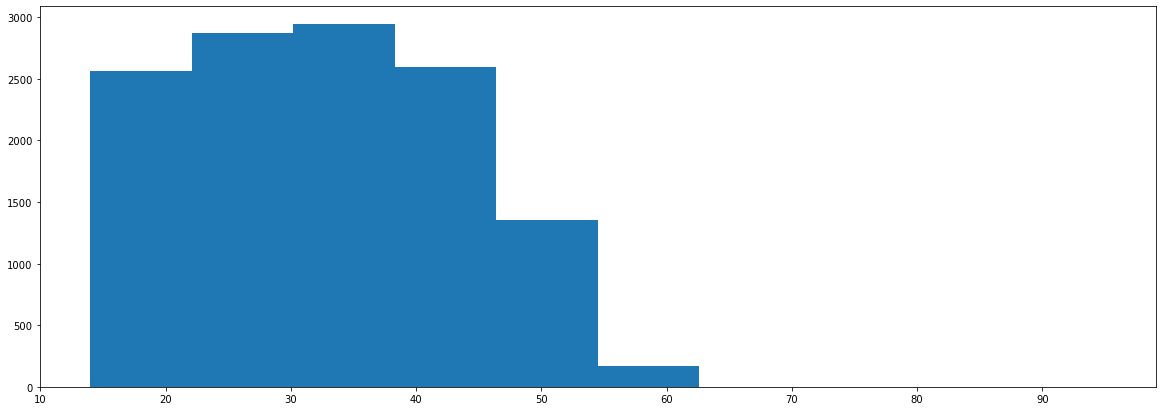

In [34]:
fig = plt.figure(1, figsize=(20, 7))
plt.hist(Enero_train['Age'])

In [35]:
#OCCUPATION
Enero_train = pd.merge(Enero_train, modes_occupation, on="Customer_ID", how="left")
#en esta linea le pongo nombre correcto a la columna que acabo de meter la moda esta guardada como cero
Enero_train.rename(columns={0:"Moda_Ocupacion"},inplace=True)
Enero_train['Occupation'].fillna(Enero_train['Moda_Ocupacion'],inplace=True)
Enero_train['Occupation']= Enero_train['Occupation'].str.replace('_______', 'Other').astype('category')

In [36]:
Enero_train['Occupation'].isna().sum()

0

(array([1621.,  779., 1597.,  788., 1530.,  784., 1543.,  782., 1531.,
        1545.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

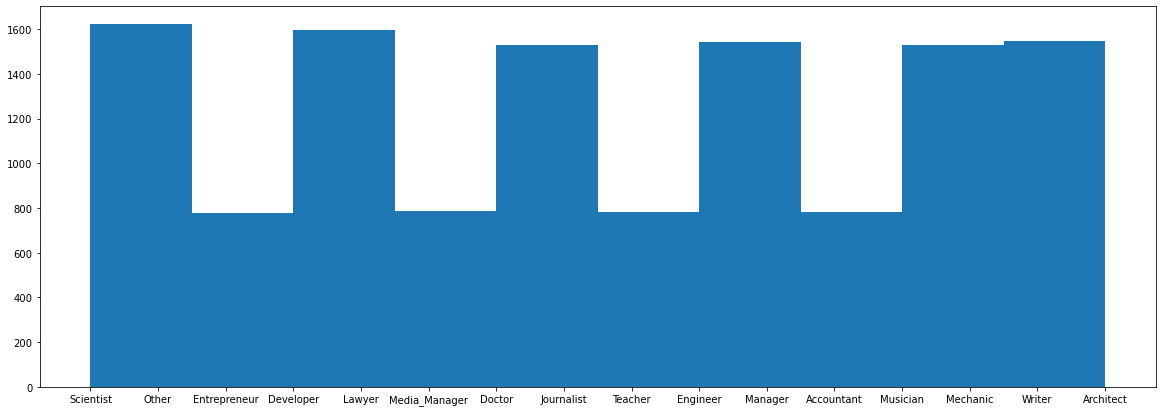

In [37]:
fig = plt.figure(1, figsize=(20, 7))
plt.hist(Enero_train['Occupation'])

In [38]:
#SALARY
Enero_train = pd.merge(Enero_train, mean_salary.to_frame(), on="Customer_ID", how="left")
#en esta linea le pongo nombre correcto a la columna que acabo de meter el promedio esta guardada como cero
Enero_train.rename(columns={0:"Promedio_salario"},inplace=True)
Enero_train['Monthly_Inhand_Salary'].fillna(Enero_train['Promedio_salario'],inplace=True)

In [39]:
Enero_train['Monthly_Inhand_Salary'].isna().sum()

0

(array([3665., 2892., 1553., 1530.,  998.,  662.,  544.,  363.,  154.,
         139.]),
 array([  303.64541667,  1793.74420833,  3283.843     ,  4773.94179167,
         6264.04058333,  7754.139375  ,  9244.23816667, 10734.33695833,
        12224.43575   , 13714.53454167, 15204.63333333]),
 <BarContainer object of 10 artists>)

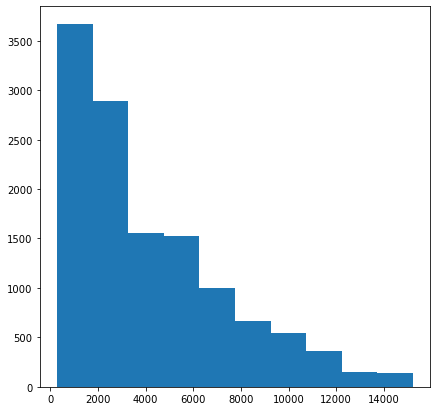

In [40]:
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Monthly_Inhand_Salary'])

In [41]:
#NUMBER_ACCOUNT
Enero_train = pd.merge(Enero_train, mode_account, on="Customer_ID", how="left")
Enero_train.rename(columns={0:'Moda_cuentas'},inplace=True)

In [42]:
#Arreglar outliers con funcion cut outliers
#1) Calcular quantiles
Enero_train['Num_Bank_Accounts'].quantile(.98)

10.0

In [43]:
Enero_train['Num_Bank_Accounts'] = Enero_train.apply(lambda x: cut_outliers(x['Num_Bank_Accounts'],10), axis=1)

In [44]:
Enero_train['Num_Bank_Accounts'].fillna(Enero_train['Moda_cuentas'],inplace=True)
Enero_train['Num_Bank_Accounts'].isna().sum()

0

(array([ 556.,  562.,  540., 1517., 1549., 1531., 1649., 1628., 1616.,
        1352.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

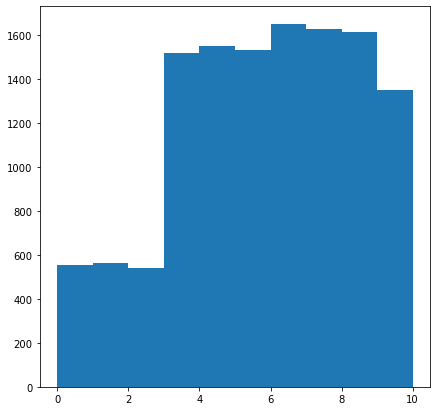

In [45]:
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Num_Bank_Accounts'])

In [46]:
#NUMBER_CREDIT_CARD
Enero_train = pd.merge(Enero_train, mode_tdc, on="Customer_ID", how="left")
Enero_train.rename(columns={0:'Moda_tdc'},inplace=True)

In [47]:
#Arreglar outliers con funcion cut outliers
#1) Calcular quantiles
Enero_train['Num_Credit_Card'].quantile(.97)

10.0

In [48]:
Enero_train['Num_Credit_Card'] = Enero_train.apply(lambda x: cut_outliers(x['Num_Credit_Card'],10), axis=1)

In [49]:
Enero_train['Num_Credit_Card'].isna().sum()
Enero_train['Num_Credit_Card'].fillna(Enero_train['Moda_tdc'],inplace=True)

(array([ 275.,  268., 1702., 1796., 2362., 2114., 2139.,  629.,  594.,
         621.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

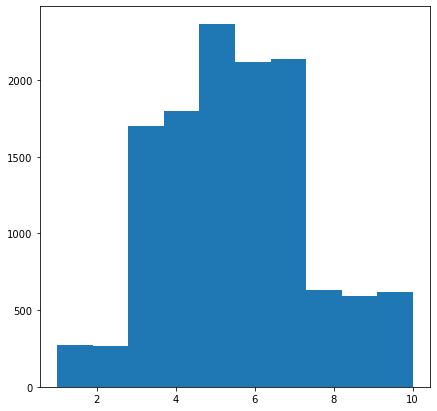

In [50]:
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Num_Credit_Card'])

In [51]:
#INTEREST_RATE
Enero_train = pd.merge(Enero_train, mode_ir, on="Customer_ID", how="left")
Enero_train.rename(columns={0:'Moda_ir'},inplace=True)
print(Enero_train['Interest_Rate'].isna().sum())
print(Enero_train["Interest_Rate"].quantile(.98))

0
34.0


0


(array([1341., 1814., 1787., 1733., 1470., 1488.,  850.,  597.,  634.,
         786.]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <BarContainer object of 10 artists>)

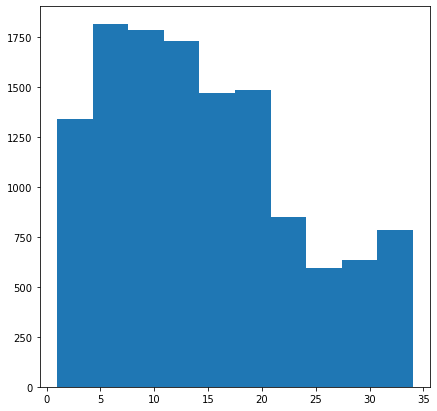

In [52]:
Enero_train['Interest_Rate'] = Enero_train.apply(lambda x: cut_outliers(x['Interest_Rate'],35), axis=1)
Enero_train['Interest_Rate'].fillna(Enero_train['Moda_ir'],inplace=True)
print(Enero_train['Interest_Rate'].isna().sum())
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Interest_Rate'])

### NUM OF LOAN

In [53]:
#INTEREST_RATE
Enero_train = pd.merge(Enero_train, mode_loan, on="Customer_ID", how="left")
Enero_train.rename(columns={0:'Moda_loan'},inplace=True)
print(Enero_train['Num_of_Loan'].isna().sum())
print(Enero_train["Num_of_Loan"].quantile(.98))

0
9.0


0


(array([1426., 1391., 1964., 1969., 1932.,  941., 1018.,  960.,  417.,
         482.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

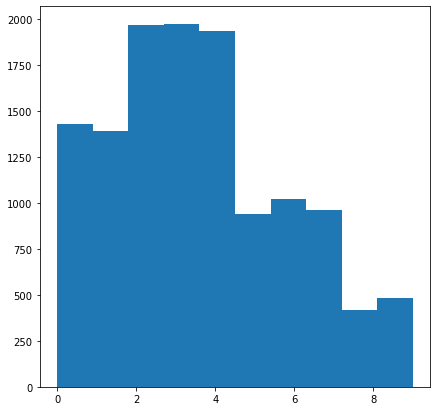

In [54]:
Enero_train['Num_of_Loan'] = Enero_train.apply(lambda x: cut_outliers(x['Num_of_Loan'],10), axis=1)
Enero_train['Num_of_Loan'].fillna(Enero_train['Moda_loan'],inplace=True)
print(Enero_train['Num_of_Loan'].isna().sum())
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Num_of_Loan'])

### Delay from Due Date

In [55]:
print(Enero_train['Delay_from_due_date'].describe())
print(Enero_train['Delay_from_due_date'].isna().sum())

count    12500.000000
mean        21.051440
std         14.859994
min         -5.000000
25%         10.000000
50%         18.000000
75%         28.000000
max         67.000000
Name: Delay_from_due_date, dtype: float64
0


(array([ 558., 2425., 2813., 2171., 2162.,  651.,  494.,  504.,  499.,
         223.]),
 array([-5. ,  2.2,  9.4, 16.6, 23.8, 31. , 38.2, 45.4, 52.6, 59.8, 67. ]),
 <BarContainer object of 10 artists>)

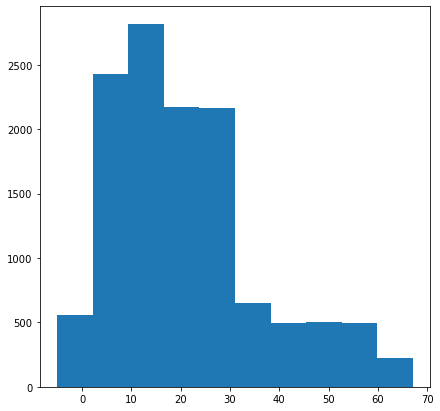

In [56]:
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Delay_from_due_date'])

### Number of Delayed Payments

In [57]:
#N DELAY
Enero_train = pd.merge(Enero_train, mode_ndelayed, on="Customer_ID", how="left")
Enero_train.rename(columns={0:'Moda_ndelay'},inplace=True)
print(Enero_train['Num_of_Delayed_Payment'].isna().sum())
print(Enero_train["Num_of_Delayed_Payment"].quantile(.98))

843
25.0


0


(array([ 269.,  782.,  814., 1676., 2097., 1788., 2141., 1803.,  813.,
         317.]),
 array([-2.,  1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28.]),
 <BarContainer object of 10 artists>)

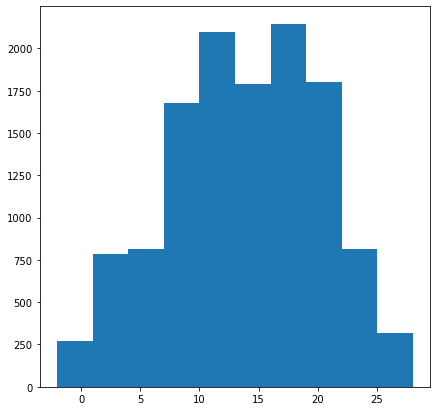

In [58]:
Enero_train['Num_of_Delayed_Payment'] = Enero_train.apply(lambda x: cut_outliers(x['Num_of_Delayed_Payment'],30), axis=1)
Enero_train['Num_of_Delayed_Payment'].fillna(Enero_train['Moda_ndelay'],inplace=True)
print(Enero_train['Num_of_Delayed_Payment'].isna().sum())
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Num_of_Delayed_Payment'])

### Changed Credit Limit

In [59]:
Enero_train = pd.merge(Enero_train, mean_chlimit, on="Customer_ID", how="left")
Enero_train.rename(columns={0:'Mean_chlimit'},inplace=True)
#Enero_train['Changed_Credit_Limit'] = Enero_train.apply(lambda x: cut_outliers(x['Changed_Credit_Limit'],30), axis=1)
Enero_train['Changed_Credit_Limit'].fillna(Enero_train['Mean_chlimit'],inplace=True)

0 -6.43 36.49


(array([  89., 1077., 2613., 3526., 2148., 1755.,  683.,  400.,  192.,
          17.]),
 array([-6.43 , -2.138,  2.154,  6.446, 10.738, 15.03 , 19.322, 23.614,
        27.906, 32.198, 36.49 ]),
 <BarContainer object of 10 artists>)

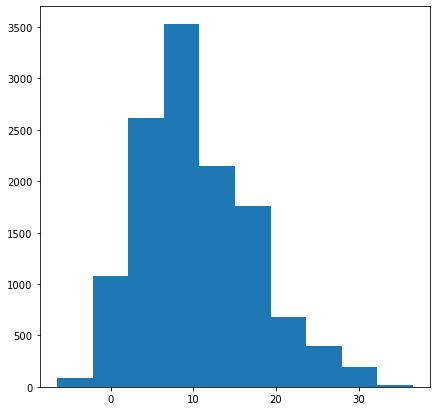

In [60]:
print(Enero_train['Changed_Credit_Limit'].isna().sum(),
      Enero_train['Changed_Credit_Limit'].min(),
     Enero_train['Changed_Credit_Limit'].max())
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Changed_Credit_Limit'])

### NUM OF CREDIT ENQUIRIES

In [61]:
Enero_train = pd.merge(Enero_train, mode_crinquiries, on="Customer_ID", how="left")
Enero_train.rename(columns={0:'mode_crinquiries'},inplace=True)
Enero_train['Num_Credit_Inquiries'] = Enero_train.apply(lambda x: cut_outliers(x['Num_Credit_Inquiries'],20), axis=1)
Enero_train['Num_Credit_Inquiries'].fillna(Enero_train['mode_crinquiries'],inplace=True)



0 0.0 17.0


(array([2535., 2523., 2112.,  990., 2025., 1155.,  583.,  564.,    9.,
           4.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

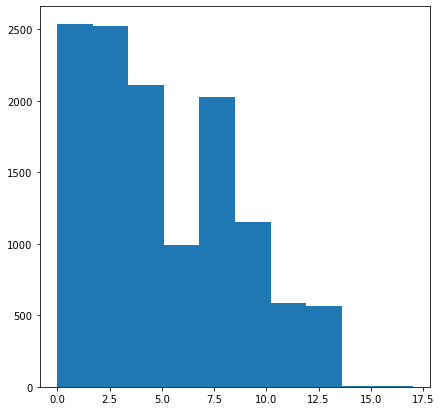

In [62]:
print(Enero_train['Num_Credit_Inquiries'].isna().sum(),
      Enero_train['Num_Credit_Inquiries'].min(),
     Enero_train['Num_Credit_Inquiries'].max())
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Num_Credit_Inquiries'])

### AMount invested Monthly

In [63]:
Enero_train = pd.merge(Enero_train, mean_amount.to_frame(), on="Customer_ID", how="left")
Enero_train.rename(columns={0:'Mean_Amount'},inplace=True)
Enero_train['Amount_invested_monthly'] = Enero_train.apply(lambda x: cut_outliers(x['Amount_invested_monthly'],6000), axis=1)
Enero_train['Amount_invested_monthly'].fillna(Enero_train['Mean_Amount'],inplace=True)

0 0.0 4486.4676998030545


(array([1.0712e+04, 9.2400e+02, 2.3400e+02, 4.2700e+02, 4.6000e+01,
        6.9000e+01, 5.6000e+01, 1.2000e+01, 1.5000e+01, 5.0000e+00]),
 array([   0.        ,  448.64676998,  897.29353996, 1345.94030994,
        1794.58707992, 2243.2338499 , 2691.88061988, 3140.52738986,
        3589.17415984, 4037.82092982, 4486.4676998 ]),
 <BarContainer object of 10 artists>)

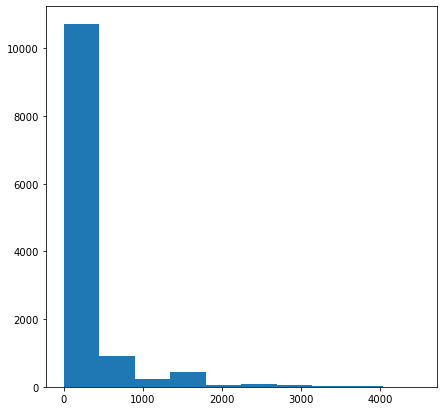

In [64]:
print(Enero_train['Amount_invested_monthly'].isna().sum(),
      Enero_train['Amount_invested_monthly'].min(),
     Enero_train['Amount_invested_monthly'].max())
fig = plt.figure(1, figsize=(7, 7))
plt.hist(Enero_train['Amount_invested_monthly'])

### Exploracion inicial de un solo mes de los datos para generar el EDA

In [65]:
Enero_train.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Moda_edad,Promedio_salario,Moda_cuentas,Moda_tdc,Moda_ir,Moda_loan,Moda_ndelay,Mean_chlimit,mode_crinquiries,Mean_Amount
count,12500.000000,1.250000e+04,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,...,12500.000000,12500.00,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000
mean,33.037200,1.888617e+05,4207.255281,5.367600,5.532480,14.532080,3.532880,21.051440,13.317200,10.409063,...,33.274560,inf,5.367520,5.532720,14.532080,3.532880,13.263600,10.393543,5.677760,637.569686
std,10.770433,1.482707e+06,3193.882623,2.592429,2.063707,8.741636,2.446442,14.859994,6.288649,6.765067,...,10.764815,inf,2.593412,2.067576,8.741636,2.446442,6.202006,6.512757,3.827382,751.542779
min,14.000000,7.005930e+03,303.645417,0.000000,1.000000,1.000000,0.000000,-5.000000,-2.000000,-6.430000,...,14.000000,303.75,-1.000000,0.000000,1.000000,0.000000,-2.000000,-5.010000,0.000000,15.292436
25%,24.000000,1.948777e+04,1629.000000,3.000000,4.000000,7.000000,2.000000,10.000000,9.000000,5.390000,...,24.000000,1626.00,3.000000,4.000000,7.000000,2.000000,9.000000,5.500000,3.000000,117.185215
50%,33.000000,3.765508e+04,3102.861667,5.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.420000,...,33.000000,3098.00,5.000000,5.000000,13.000000,3.000000,14.000000,9.340000,5.000000,233.589940
75%,41.000000,7.289813e+04,5971.334167,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,14.792500,...,42.000000,5960.00,7.000000,7.000000,20.000000,5.000000,18.000000,14.672500,8.000000,1336.541021
max,95.000000,2.365819e+07,15204.633333,10.000000,10.000000,34.000000,9.000000,67.000000,28.000000,36.490000,...,56.000000,15208.00,10.000000,11.000000,34.000000,9.000000,28.000000,29.980000,17.000000,5748.505316


Profiling de los datos tomando solo ciertas caracteristicas basicas iniciales

In [66]:
#columnas de descripcion general fast EDA
columnas_FEDA=[ 'Age', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score']

In [67]:
Enero_train_EDA=Enero_train[columnas_FEDA]

In [68]:
profile_Enero=pp.ProfileReport(Enero_train_EDA)

In [69]:
profile_Enero.to_file('EneroProfiling.html')

Summarize dataset:   0%|          | 0/37 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## CHAVOS:

1) El procedimiento anterior se tiene que repetir para cada mes despues de calcular las modas y medias. Es decir, a partir de la celda que dice:

### Merges finales para quitar missings y outliers no naturales (errores no relacionados con la distribucion)

2) Los datos que ya estan limpios y listos para usar son los de Enero, son los que presentaremos en el EDA de esta semana. Los demas meses solo es repetir lo que ya se hizo

In [71]:
Enero_train.to_csv("Data/Enero_train.csv")